In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('wine.csv', header = None)

# Naive Bayes Gaussian

In [3]:
# Note: the input to the methods should be pandas dataframes, especially that feature_set has to be 2-d
class NaiveBayesGaussian():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(pd.DataFrame(class_labels), complete_set, sort=False)
        self.class_labels = class_labels
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        self.cov_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).var().iloc[:, 1:]
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[0]) / np.sqrt(cov_params[0]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[0]))
                likelihood_1 = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[1]) / np.sqrt(cov_params[1]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[1]))
                numerator_0 = pi_params[0] * np.prod(likelihood_0)
                numerator_1 = pi_params[1] * np.prod(likelihood_1)
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold:
                    group_set[i] = self.class_labels[0]
                else:
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[r]) / np.sqrt(cov_params[r]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[r]))
                    class_prob = pi_params[r] * np.prod(likelihood)
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
    
        return group_set.ravel().astype(int)

# Linear Discriminant Analysis

In [4]:
# Note: the input to the methods should be pandas dataframes
class LinearDiscriminantAnalysis():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(pd.DataFrame(class_labels), complete_set, sort=False)
        self.class_labels = class_labels
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        self.cov_params = sorted_complete_set.iloc[:, 1:].cov()
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[0]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[0])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                likelihood_1 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[1]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[1])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                numerator_0 = pi_params[0] * likelihood_0
                numerator_1 = pi_params[1] * likelihood_1
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold:
                    group_set[i] = self.class_labels[0]
                else: 
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[r]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[r])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                    class_prob = pi_params[r] * likelihood
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
        
        return group_set.ravel().astype(int)
        

# Quadratic Discriminant Analysis

In [5]:
# Note: the input to the methods should be pandas dataframes
class QuadraticDiscriminantAnalysis():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(pd.DataFrame(class_labels), complete_set, sort=False)
        self.class_labels = class_labels
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        cov_params = []
        for i in class_labels:
            cov_class = sorted_complete_set[sorted_complete_set.iloc[:, 0] == i].iloc[:, 1:].cov()
            cov_params.append(cov_class)
        self.cov_params = cov_params
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[0]), np.linalg.inv(cov_params[0]), np.transpose(feature_set[i] - mu_params[0])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[0])))
                likelihood_1 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[1]), np.linalg.inv(cov_params[1]), np.transpose(feature_set[i] - mu_params[1])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[1])))
                numerator_0 = pi_params[0] * likelihood_0
                numerator_1 = pi_params[1] * likelihood_1
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold: # probability threshold for classifying into the first group
                    group_set[i] = self.class_labels[0]
                else: 
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[r]), np.linalg.inv(cov_params[r]), np.transpose(feature_set[i] - mu_params[r])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[r])))
                    class_prob = pi_params[r] * likelihood
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
                
        return group_set.ravel().astype(int)
        

# Loss function

In [6]:
def loss(y, y_pred, type_of_loss=None):
    y = np.array(y)
    y_pred = np.array(y_pred)
    if type_of_loss == 'mse':
        loss = (y - y_pred) ** 2 / len(y)
        return loss
    elif type_of_loss == '0-1':
        # binary classification
        # assume that wine type 1 is for positive, type 2 is for negative
        # however, we have to reassign the group numbers if we classify wine type 3
        if len(np.unique(y_pred)) <= 2:
            loss = np.sum(y != y_pred)
            # false positive: true 2 classified as 1
            type_i_error = np.sum(y_pred < y)
            # false negative: true 1 classified as 2
            type_ii_error = np.sum(y < y_pred)
            return loss, type_i_error, type_ii_error
        else:
            loss = np.sum(y != y_pred)
            return loss
    else: 
        message = 'type of error not specified'
        return message

# Visualize the chosen feature

In [7]:
# Select two types of wine
data_1 = data[data.iloc[:, 0].isin([1, 2])]
class_labels = np.array([1, 2])
# Choose one predictor
feature_set = data_1.iloc[:, 1]
group_set = data_1.iloc[:, 0]

<AxesSubplot:>

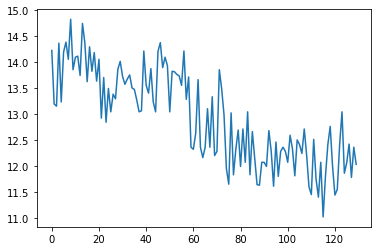

In [8]:
feature_set.plot()

The plot shows that class 2 is relatively low in the amount of feature 1.

# Binary classification with one feature

## LDA: Training error

In [9]:
lda = LinearDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = lda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      11
type_i_error      4
type_ii_error     7
dtype: int32


## LDA: Classfication result plot

In [10]:
mu_0 = lda.mu_params.iloc[0, 0]
mu_1 = lda.mu_params.iloc[1, 0]
cov = lda.cov_params.iloc[0, 0]
pi_0 = lda.pi_params[1]
pi_1 = lda.pi_params[2]

decision_boundary = 0.5 * (mu_0 + mu_1) - (np.log(pi_0) - np.log(pi_1)) / ((mu_0 - mu_1) / cov)

<function matplotlib.pyplot.show(close=None, block=None)>

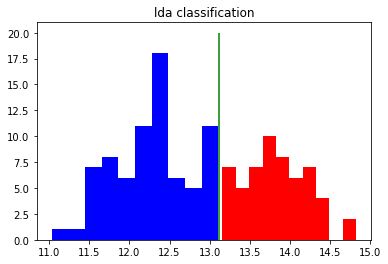

In [11]:
fig = plt.figure()

lda_plot_1 = feature_set
lda_plot_2 = group_set_pred
lda_plot = np.column_stack((lda_plot_1, lda_plot_2))
lda_plot_x1 = lda_plot[lda_plot[:, 1] == 1]
lda_plot_x2 = lda_plot[lda_plot[:, 1] == 2]

zeros1 = np.zeros((len(lda_plot_x1[:, 0]), 1))
zeros2 = np.zeros((len(lda_plot_x2[:, 0]), 1))
plt.hist(lda_plot_x1[:, 0], color='red')
plt.hist(lda_plot_x2[:, 0], color='blue')
plt.vlines(decision_boundary, 0, 20, color='green')

plt.title('lda classification')
plt.show

## LDA: LOOCV error

In [24]:
import math

In [25]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = LinearDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int32


## QDA: Training error

In [26]:
qda = QuadraticDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = qda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int32


## QDA: Classification result plot

<function matplotlib.pyplot.show(close=None, block=None)>

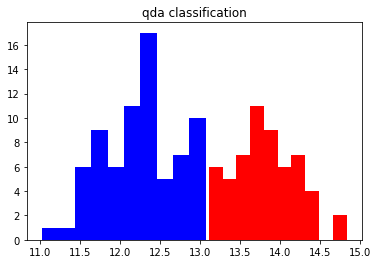

In [27]:
fig = plt.figure()

qda_plot_1 = feature_set
qda_plot_2 = group_set_pred
qda_plot = np.column_stack((qda_plot_1, qda_plot_2))
qda_plot_x1 = qda_plot[qda_plot[:, 1] == 1]
qda_plot_x2 = qda_plot[qda_plot[:, 1] == 2]

zeros1 = np.zeros((len(qda_plot_x1[:, 0]), 1))
zeros2 = np.zeros((len(qda_plot_x2[:, 0]), 1))
plt.hist(qda_plot_x1[:, 0], color='red')
plt.hist(qda_plot_x2[:, 0], color='blue')

plt.title('qda classification')
plt.show

## QDA: LOOCV error

In [28]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = QuadraticDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int32


## NBG: Training error

In [29]:
nbg = NaiveBayesGaussian().fit(feature_set, group_set, class_labels)
group_set_pred = nbg.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int32


## NBG: Classification result plot

<function matplotlib.pyplot.show(close=None, block=None)>

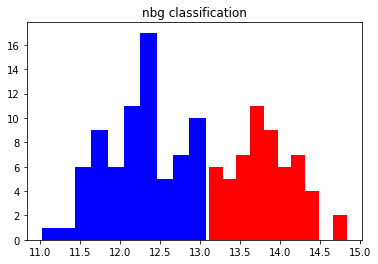

In [30]:
fig = plt.figure()

nbg_plot_1 = feature_set
nbg_plot_2 = group_set_pred
nbg_plot = np.column_stack((nbg_plot_1, nbg_plot_2))
nbg_plot_x1 = nbg_plot[nbg_plot[:, 1] == 1]
nbg_plot_x2 = nbg_plot[nbg_plot[:, 1] == 2]

zeros1 = np.zeros((len(nbg_plot_x1[:, 0]), 1))
zeros2 = np.zeros((len(nbg_plot_x2[:, 0]), 1))
plt.hist(nbg_plot_x1[:, 0], color='red')
plt.hist(nbg_plot_x2[:, 0], color='blue')

plt.title('nbg classification')
plt.show

## NBG: LOOCV error

In [31]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = NaiveBayesGaussian().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int32


## Performance of the classifiers

We can't observe too much difference among the classifiers. I think the performance in general is not bad, because the sample size is over 120, and there are just over 10 which are miss classified, resulting in an (training and LOOCV) error rate of just around 0.1. And there is very little overfit. This could be because that the features within each class follow Gaussian distribution as assumed by LDA. The covariance within each class doesn't differ much, so QDA doesn't outperform LDA too much.

# Binary classification with 2 features

In [32]:
# Select two types of wine
data_1 = data[data.iloc[:, 0].isin([1, 2])]
class_labels = np.array([1, 2])
# Choose one predictor
feature_set = data_1.iloc[:, 1 : 3]
group_set = data_1.iloc[:, 0]

In [40]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = feature_set.iloc[:, 0].min() - .5, feature_set.iloc[:, 0].max() + .5
    y_min, y_max = feature_set.iloc[:, 1].min() - .5, feature_set.iloc[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(feature_set.iloc[:, 0], feature_set.iloc[:, 1], c=group_set, cmap=plt.cm.Spectral)

## LDA: Training error

In [36]:
lda = LinearDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = lda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      13
type_i_error      6
type_ii_error     7
dtype: int32


## LDA: Decision boundary

Text(0.5, 1.0, 'Linear Discriminant Analysis')

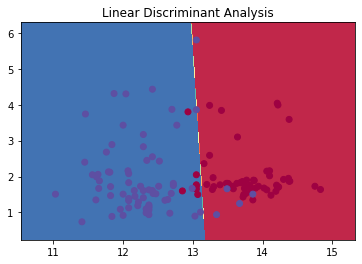

In [41]:
# Plot the decision boundary
plot_decision_boundary(lambda x: lda.predict(x))
plt.title("Linear Discriminant Analysis")

## LDA: ROC curve

In [42]:
meshgrid = np.linspace(0, 1, num = 1000)

In [43]:
# total class 1 items
total_positive = data_1.groupby(data_1.iloc[:, 0]).count().iloc[0, 0]
# total class 2 items
total_negative = data_1.groupby(data_1.iloc[:, 0]).count().iloc[1, 0]

In [44]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = lda.predict(feature_set, threshold)
    type_i_error = loss(group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

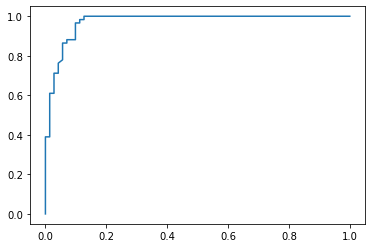

In [45]:
plt.plot(false_positive_rate_all, true_positive_rate_all, 1, 1)

In [46]:
# Keep the decimal places
true_positive_rate_all = np.array(true_positive_rate_all)
false_positive_rate_all = np.array(false_positive_rate_all)
# Area under the curve
area = 0
for i in range(len(meshgrid) - 1):
    area += (true_positive_rate_all[i+1] - true_positive_rate_all[i]) * (false_positive_rate_all[i+1] - false_positive_rate_all[i])
    
area = 1 - area
area_under_the_curve = (area + 1) / 2

In [47]:
area_under_the_curve

0.9998806397708284

## LDA: LOOCV error

In [48]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = LinearDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      13
type_i_error      6
type_ii_error     7
dtype: int32


## QDA: Training error

In [49]:
qda = QuadraticDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = qda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int32


## QDA: Decision boundary

Text(0.5, 1.0, 'Quadratic Discriminant Analysis')

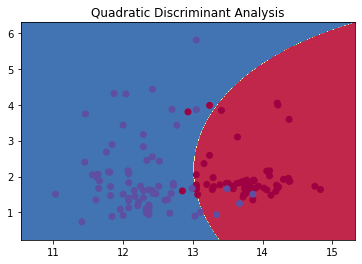

In [50]:
# Plot the decision boundary
plot_decision_boundary(lambda x: qda.predict(x))
plt.title("Quadratic Discriminant Analysis")

## QDA: ROC curve

In [51]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = qda.predict(feature_set, threshold)
    type_i_error = loss(group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

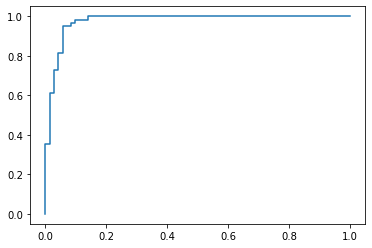

In [52]:
plt.plot(false_positive_rate_all, true_positive_rate_all, 1, 1)

In [53]:
# Keep the decimal places
true_positive_rate_all = np.array(true_positive_rate_all)
false_positive_rate_all = np.array(false_positive_rate_all)
# Area under the curve
area = 0
for i in range(len(meshgrid) - 1):
    area += (true_positive_rate_all[i+1] - true_positive_rate_all[i]) * (false_positive_rate_all[i+1] - false_positive_rate_all[i])
    
area = 1 - area
area_under_the_curve = (area + 1) / 2

In [54]:
area_under_the_curve

1.0

## QDA: LOOCV error

In [55]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = QuadraticDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int32


## NBG: Training error

In [56]:
nbg = NaiveBayesGaussian().fit(feature_set, group_set, class_labels)
group_set_pred = nbg.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int32


## NBG: Decision boundary

Text(0.5, 1.0, 'Naive Bayes Gaussian')

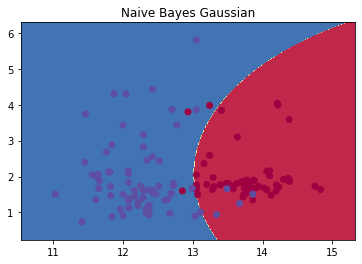

In [57]:
# Plot the decision boundary
plot_decision_boundary(lambda x: nbg.predict(x))
plt.title("Naive Bayes Gaussian")

## NBG: ROC curve

In [58]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = nbg.predict(feature_set, threshold)
    type_i_error = loss(group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

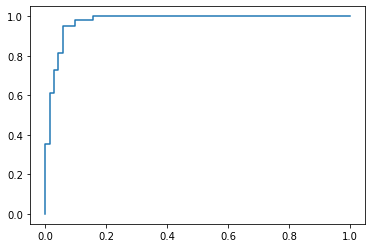

In [59]:
plt.plot(false_positive_rate_all, true_positive_rate_all, 1, 1)

In [60]:
# Keep the decimal places
true_positive_rate_all = np.array(true_positive_rate_all)
false_positive_rate_all = np.array(false_positive_rate_all)
# Area under the curve
area = 0
for i in range(len(meshgrid) - 1):
    area += (true_positive_rate_all[i+1] - true_positive_rate_all[i]) * (false_positive_rate_all[i+1] - false_positive_rate_all[i])
    
area = 1 - area
area_under_the_curve = (area + 1) / 2

In [61]:
area_under_the_curve

1.0

## NBG: LOOCV error

In [62]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = NaiveBayesGaussian().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      8
type_i_error     5
type_ii_error    3
dtype: int32


# 3-Classes classification with many features

In [63]:
group_set = data.iloc[:, 0]
feature_set = data.iloc[:, 1:]
class_labels = group_set.unique()

## LDA: Training error

In [64]:
lda = LinearDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = lda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    0
dtype: int32


## LDA: LOOCV error

In [66]:
n_train = data.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0

for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = LinearDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]

result = pd.Series([total_error], index = ['total_error'])
print(result)

total_error    1
dtype: int32


## QDA: Training error

In [68]:
qda = QuadraticDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = qda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    1
dtype: int32


## QDA: LOOCV error

In [70]:
n_train = data.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0

for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = QuadraticDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]

result = pd.Series([total_error], index = ['total_error'])
print(result)

total_error    1
dtype: int32
